# Testing the trained AlexNet model on Dogs vs Catas dataset

AlexNet is a Convolution Neural Network proposed by [Alex Krizhevsky et al.](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) in 2012, obtaining the best result on  LSVRC-2010. The model consists by eight learned layers (five convolutional and three fully-connected layers). In the original work the authors consider a Patch Crop as augmentation and, the mean subtraction of the channels colors, putting the raw of pixels around zero. To train our model we assume the same assumptions.

We've trained the model on the Dogs vs Cats dataset. The train script is found here. The input size considered here is (227x227) and, besides considering the batch normalization. In this note book, we test the trained model using the cropPreprocessor that generates images cropped in the corners (left, right, up, down, center). We then test the model on the cropped images and the average result. 

## Importing Libraries

In [1]:
from config import dogs_vs_cats_config as config
from compvis.preprocessing import ImageToArrayPreprocessor
from compvis.preprocessing import SimplePreprocessor
from compvis.preprocessing import MeanPreprocessor
from compvis.preprocessing import CropPreprocessor
from compvis.callbacks import TrainingMonitor
from compvis.io import HDF5DatasetGenerator
from compvis.utils.ranked import rank5_accuracy
from tensorflow.keras.models import load_model
import numpy as np
import json
import matplotlib.pyplot as plt

## Loading the trained model

In [2]:
# Loading the pre-trained network
model = load_model(config.MODEL_PATH)

**Visualizing the model architecture**

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 57, 57, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 57, 57, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 57, 57, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0

**Visualizing the training results**

The model was trained with $20000$ images on the training set and $2000$ for the validation set. We consider the Adam as regularization and learning rate of $1e-3$. The total number of epochs was $75$

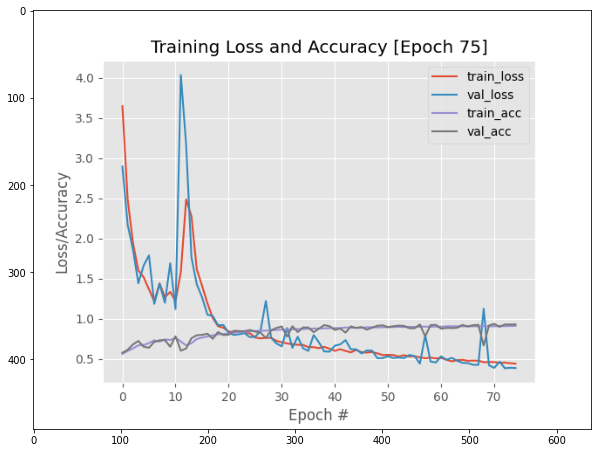

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(plt.imread("output/2414.png"))
plt.show()

## Setting the image preprocessors and test set

In [5]:
# Loading the RGB mean for the test set
means = json.loads(open(config.DATASET_MEAN).read())

In [6]:
# Initializing the image preprocessors
sp = SimplePreprocessor(227, 227)
mp = MeanPreprocessor(means["R"], means["G"], means["B"])
cp = CropPreprocessor(227, 227)
iap = ImageToArrayPreprocessor()

In [7]:
testGen = HDF5DatasetGenerator(config.TEST_HDF5, 64, 
                               preprocessors = [sp, mp, iap], 
                               classes = 2)

## Making prediction without the crop method

In [8]:
prediction = model.predict(testGen.generator(), steps=testGen.numImages//64,
                          max_queue_size=64*2)

In [9]:
(rank1, _) = rank5_accuracy(prediction, testGen.db["labels"])
print("[INFO] rank-1: {: .2f}%".format(rank1*100))
testGen.close()

[INFO] rank-1:  92.48%


## Making prediction with the crop method

In [10]:
testGen = HDF5DatasetGenerator(config.TEST_HDF5, 64,  preprocessors = [mp], classes = 2)
predictions = []

In [11]:
# Loop over the images to apply the crop technique
for (i, (images, labels)) in enumerate(testGen.generator(passes=1)):
    # Loop over each indivudual image
    for image in images:
        # applying the crop
        crops = cp.preprocess(image) # generating  10 images and crop them
        crops = np.array([iap.preprocess(c) for c in crops], dtype= "float32") # Using the iap to convert the images into array and converting the list of images into an array
        
        # Making prediction on the 10 cropped images
        pred = model.predict(crops)
        # Taking the mean of predictions
        predictions.append(pred.mean(axis = 0))

In [12]:
print("[INFO] predicting on test data (with crops)...")
(rank1, _) = rank5_accuracy(predictions, testGen.db["labels"])
print("[INFO] rank-1: {:.2f}%".format(rank1 * 100))
testGen.close()

[INFO] predicting on test data (with crops)...
[INFO] rank-1: 94.08%


## Conclusion

The AlexNet architecture on Dogs vs Cats shows that the learning curvas are closed. At the end of the training process we have $91.63\%$ of accuracy, for the training test, $93.1\%$ for the validation set. Considering the test set without the crop preprocessor, the accuracy was $92.48\%$, with the crop, the obtained accuracy was $94\%$, that's a very good results. To improve, we can maybe increase the number of epochs or get more data, but in this state, we already have a good model, considering thata the objective it the training about computer vision.